In [160]:
%pylab inline
from pylab import *
import cv2
from skimage.transform import resize
import math

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/julian/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['power', 'resize', 'random', 'fft']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
def read_im(filepath):
    if filepath[len(filepath)-3:] == 'tif':
        return imread(filepath)/65536.0
    return imread(filepath)/255.0

im = read_im('../data/cathedral.jpg')

print("Size of the image is %d x %d" % (im.shape[0], im.shape[1]))
print("Size of the individual plates is %d x %d" % (im.shape[0] // 3, im.shape[1]))


Size of the image is 1024 x 390
Size of the individual plates is 341 x 390


In [3]:
def translate(im, ty, tx):
    """
    Helper function that translates an image.
    """
    height, width = im.shape[:2]
    mat = translation_matrix = np.array([
        [1, 0, tx],
        [0, 1, ty]
    ], dtype=np.float32)
    return cv2.warpAffine(im, mat, (width, height))

In [154]:
def crop(image, y, x):
    # Crops y pixels off the top and bottom and x pixels off the sides
    
    return image[y:image.shape[0]-y, x:image.shape[1]-x]

In [5]:
def separate_images(image):
    """
    Helper Function.
    Returns a tuple of (blue_image, green_image, red_image) separated from one monolithic image.
    """
    # Extract the 3 images
    height = image.shape[0] // 3
    width  = image.shape[1]
    blu_im = image[          :height, :width]
    gre_im = image[  height:2*height, :width]
    red_im = image[2*height:3*height, :width]
    
    return (blu_im, gre_im, red_im)

In [156]:
def ncc(u, v):
    """
    Normalized Cross Correlation
    """
    u_norm = u / np.linalg.norm(u)
    v_norm = v / np.linalg.norm(v)
    return np.dot(u_norm.ravel(), v_norm.ravel())


In [155]:
def translate_and_composite(images, gre_allign, red_allign):
    """
    Helper function.
    images is a tuple of greyscale images to be composited:
        images = (blue_image, green_image, red_image)
    
    returns an image with color, with the green and red images translated
    """    
    height = images[0].shape[0]
    width = images[0].shape[1]

    gre_ty, gre_tx = gre_allign
    red_ty, red_tx = red_allign

    composite = np.zeros((height, width, 3))
    
    blue = images[0]
    green = translate(images[1], gre_ty, gre_tx)
    red = translate(images[2], red_ty, red_tx)

    for y in range(0, height):
        for x in range(0, width):
            composite[y][x][0] = red[y][x]
            composite[y][x][1] = green[y][x]
            composite[y][x][2] = blue[y][x]
    
    return composite

In [157]:
def colorize(image, gre_allign, red_allign):
    """
    Colorizes a set of 3 Blue Green Red greyscale images.
    Inputs:
        image: a single image that is a vertical stack of 3 equal sized greyscal images
        gre_allign, red_allign: tuples that represent the translations for allignment
    """
    # Extract images representing color channels
    blu_im, gre_im, red_im = separate_images(image)
    
    composite = adjust_and_composite((blu_im, gre_im, red_im), gre_allign, red_allign)
    
    return composite
    

In [162]:
def create_pyramid(image):
    # Figure out how many levels could cleanly fit into image. Either log_2(height) or log_2(width)
    levels_y = math.floor(int(math.log(image.shape[1], 2)))
    levels_x = math.floor(int(math.log(image.shape[0], 2)))
    num_levels = min(levels_y, levels_x)
    pyramid = []
    for i in reversed(range(0,num_levels)):
        scale = 2**i
        pyramid.append(resize(image, (image.shape[0]//scale, image.shape[1]//scale)))
    return pyramid

In [158]:
def align(u, v, estimate, scan):
    """
        New version of allign that uses some formulas I came up with to 
        crop v with so that we never have any out of bounds indexing errors.
    """
    ty, tx = estimate[:2]
    h, w = v.shape[:2]

    # crop about 10% of the edges, make sure not to have this values be bad
    crop_y = 
    crop_x = 

    if crop_y >= h - crop_y or crop_x >= w - crop_x:
        return allign_v2(u, v, estimate, scan-1)
    
    max_ncc = -1
    (best_dy, best_dx) = (None, None)

    # Crop v down to a size that will allow searching the entire search area (Defined above).
    v_crop = v[crop_y:-crop_y, crop_x:-crop_x]

    # Scan through the search area range and pick the translation with the best Normalized Cross Correlation.
    for dy in range(-scan, scan+1):        
        for dx in range(-scan, scan+1):
            # Define the currently selected area.
            sel_min_y = crop_y + dy
            sel_max_y = h - crop_y + dy
            sel_min_x = crop_x + dx
            sel_max_x = w - crop_x + dx
            # Get the cropped selection of image u.
            u_crop = u[sel_min_y:sel_max_y, sel_min_x:sel_max_x]
            # Calculate the Normalized Cross Correlation. Greater is better.
            score = ncc(u_crop, v_crop)
            if score > max_ncc:
                max_ncc = score
                (best_dy, best_dx) = (dy, dx)
    
    new_best_est = (best_dy, best_dx)
    return new_best_est

SyntaxError: invalid syntax (1412753604.py, line 10)

### The image pyramid will start at a course resolution, i.e. 1/8 the original image resolution. Then it will run the previously developed allignment logic on the images at that resolution. Next it will increase to 1/4 resolution and using the previous esimate at the best translation it will search "near" to that and update the estimate. Keep doubling the resolution until you reach full resolution. This reduces the computation necessary to search for allignment.

In [159]:
def align_and_colorize(image_filepath):
    """
    Call colorize() on course to fine versions of image.
    Each time update the estimated translation.
    """
    full_image = read_im(image_filepath)
    
    # Create subsampled versions of image, from x1/8 to x1 scale
    pyramid = create_pyramid(image)
    
    # Initialize variables
    scan_range = initial_scan_range
    green_est = red_est = (0,0)
    
    for im in pyramid:
        # Scale estimate translations by 2 to account for scaling
        green_est = [coord * 2 for coord in green_est]
        red_est = [coord * 2 for coord in red_est]
        # Extract the images from the monolithic image.
        (blue, green, red) = separate_images(im)
        # Update the estimate for the green and red translation
        green_est = allign(blue, green, green_est, scan_range)
        red_est = allign(blue, red, red_est, scan_range)
        #Decrease the scan range
        scan_range = scan_range - scan_range // 10

    composite = colorize(image, green_est, red_est)
    h, w = composite.shape[:2]
    cropped_composite = composite[final_crop:(h-final_crop), final_crop:(w-final_crop)]
    
    return cropped_composite, green_est, red_est


In [20]:
def test_colorize_pyramid(filepath, scan_range):
    (image, gre_offset, red_offset) = colorize_pyramid(read_im(filepath), scan_range, 20, 20)
    print(gre_offset, red_offset)
    imshow(image)

In [153]:
test_colorize_pyramid('../data/tobolsk.jpg', 10)

NameError: name 'c' is not defined

(-3, 2) (3, 2)


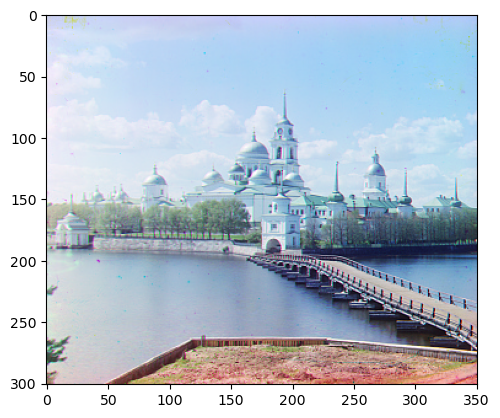

In [142]:
test_colorize_pyramid('../data/monastery.jpg', 10)

(5, 2) (11, 3)


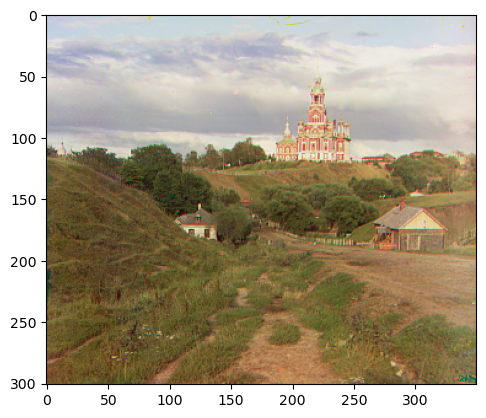

In [143]:
test_colorize_pyramid('../data/cathedral.jpg', 15)

(9, 4) (9, -5)


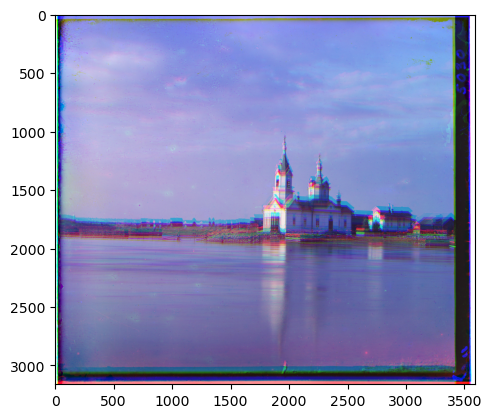

In [144]:
test_colorize_pyramid('../data/church.tif', 11)

(25, 4) (45, -5)


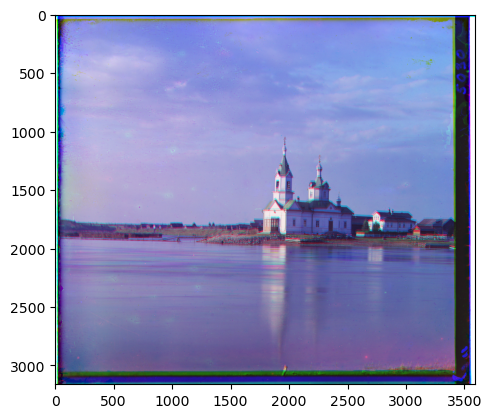

In [98]:
test_colorize_pyramid('../data/church.tif', 60)

(23, -7) (30, -13)


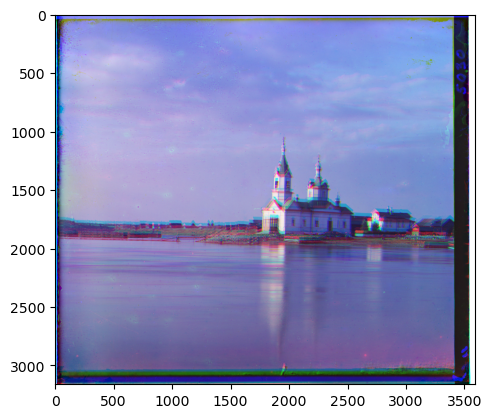

In [62]:
test_colorize_pyramid('../data/church.tif', 30) # one level pyramid test

(5, -8) (50, -12)


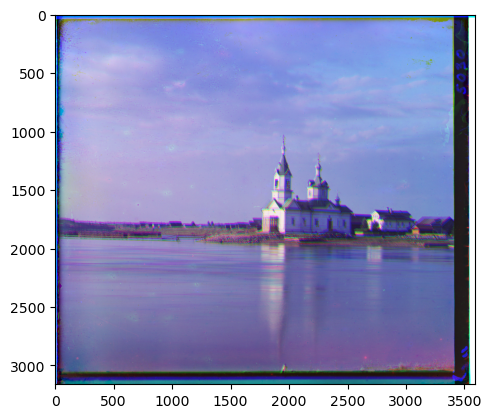

In [64]:
#really big range test (this is gonna take a while)
test_colorize_pyramid('../data/church.tif', 50) # one level pyramid test

(25, 2) (57, -5)


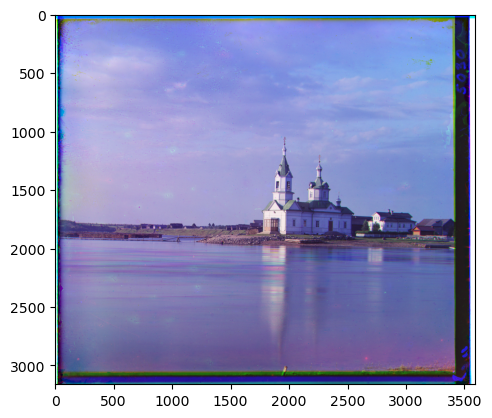

In [65]:
# ok that was a big improvement but we're still maxing out the search range! lets go higher!!
test_colorize_pyramid('../data/church.tif', 100) # one level pyramid test

In [146]:
church = colorize(read_im('../data/church.tif'), (25, 2), (57, -5))

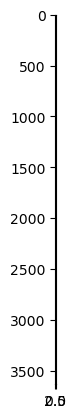

In [147]:
imshow(church[0])

In [ ]:
test_colorize_pyramid('../data/emir.tif', 30)

In [ ]:
test_colorize_pyramid('../data/onion_church.tif', 30)